In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.special import erfc                         # Error function, to get integral of Gaussian
r = np.random

In [2]:
sys.path.append('../AppStat2023/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   

In [3]:
blind = True

In [4]:
def Chauvenet(data): #Chauvenet med 1/4-del som kriterium frem for 1/2
    n = 1
    data_subset = data
    while n>0:
        n_bef = len(data_subset)
        mask = (len(data_subset) * erfc(abs(data_subset - data_subset.mean()) / data_subset.std(ddof=1))) >= .05
        data_subset = data_subset[mask]
        n = n_bef - len(data_subset)
        print(n)
    return data_subset, len(data)-len(data_subset)

In [5]:
def constant(x,c):
    return c

def fit(fit, x, y, sy):
    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    
    chi2fit = Chi2Regression(fit, x, y, sy)
    
    minuit_chi2 = Minuit(chi2fit, c=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    return minuit_chi2

In [6]:
def weighted_mean(y_data, y_err):
    mean = fit(constant,  # fit function
               np.arange(len(y_data)), # arbitrary x_values
               y_data, # y-data
               y_err # y-error
              )
    for name in mean.parameters:
        value, error = mean.values[name], mean.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")
    w_mean = mean.values['c']
    w_err  = mean.errors['c'], 
    chi2_value = mean.fval
    Ndof_value = len(y_data)-1 # data-points - 1 parameter
    prob = stats.chi2.sf(chi2_value, Ndof_value)
    return w_mean, w_err, chi2_value, prob

In [7]:
# Vi er 'lige blinde' på alle målinger af samme gate, men ikke på hver gate... Skal de alle forskydes lige meget i stedet måske?
# Vi er ikke blinde på '0'

if blind:
    blinding = np.ones(5)*r.normal(0,5) # r.normal(0, 5, size=5) 
else:
    blinding = np.zeros(5)

#positioner af målere
person1_pos = np.array([19.25, 35.48, 53.45, 69.95, 87.75]) + blinding #cm
person1_pos += -person1_pos[0] # Sætter den første som 0 punkt
person1_pos_sigma = np.array([0.1]) #np.array([0.05]) #cm

person2_pos = np.array([17, 33.6, 51.4, 67.7, 85.6]) + blinding #cm
person2_pos += -person2_pos[0]
person2_pos_sigma = np.array([0.1]) #cm

person3_pos = np.array([12.10, 29.85, 46.35, 64.05, 80.65]) + blinding #cm
person3_pos += -person3_pos[0]
person3_pos_sigma = np.array([0.1]) #np.array([0.05]) #cm

person4_pos = np.array([11.24, 29.00, 45.43, 63.01, 79.84]) + blinding #cm
person4_pos += -person4_pos[0]
person4_pos_sigma = np.array([0.1]) #np.array([0.02]) #cm


# Alternative weighted mean:
#weighted_sigma = 1/np.sqrt(person1_pos_sigma**(-2) + person2_pos_sigma**(-2) + person3_pos_sigma**(-2) + person4_pos_sigma**(-2))
#weighted_pos = person1_pos*person1_pos_sigma**(-2) + person2_pos*person2_pos_sigma**(-2) + person3_pos*person3_pos_sigma**(-2) + person4_pos*person4_pos_sigma**(-2)
#weighted_pos *= weighted_sigma**(2)

gate_pos = np.zeros(len(person1_pos))
gate_err = np.zeros(len(person1_pos))

for i in range(len(person1_pos)):
    mean, err, chi2, prob = weighted_mean(
        [person1_pos[i], person2_pos[i], person3_pos[i], person4_pos[i]],
        [person1_pos_sigma[0], person2_pos_sigma[0], person3_pos_sigma[0], person4_pos_sigma[0]]
                                   )
    print(prob)
    gate_pos[i]+=mean
    gate_err[i]+=err[0]

Fit value: c = 0.00000 +/- 0.05000
1.0
Fit value: c = 17.08500 +/- 0.05000
3.6397268830395596e-40
Fit value: c = 34.26000 +/- 0.05000
0.42021813476717285
Fit value: c = 51.28000 +/- 0.05000
2.5179098004044856e-29
Fit value: c = 68.56250 +/- 0.05000
0.8761400628270306


In [8]:
person1_pos, person2_pos,person3_pos,person4_pos,

(array([ 0.  , 16.23, 34.2 , 50.7 , 68.5 ]),
 array([ 0. , 16.6, 34.4, 50.7, 68.6]),
 array([ 0.  , 17.75, 34.25, 51.95, 68.55]),
 array([ 0.  , 17.76, 34.19, 51.77, 68.6 ]))

In [9]:
#Implermentering af Chauvenet! - Fjerner ét datum
for i in range(1, len(person1_pos)):
    pos = np.array([person1_pos[i], person2_pos[i], person3_pos[i], person4_pos[i]])
    pos_new, n_pos = Chauvenet(pos)
    print(pos_new)

0
[16.23 16.6  17.75 17.76]
0
[34.2  34.4  34.25 34.19]
0
[50.7  50.7  51.95 51.77]
0
[68.5  68.6  68.55 68.6 ]


In [10]:
if blind:
    blinding = r.normal(0, 3, size=2)
else:
    blinding = np.zeros(2)

#trigonometri
person1_height_length = np.array([22.05, 89.9])+blinding #cm height, length
person1_hl_sigma = np.array([0.05]) #cm

person2_height_length = np.array([22.1, 90.1])+blinding #cm height, length
person2_hl_sigma = np.array([0.2]) #cm

person3_height_length = np.array([22.7, 93.1])+blinding #cm height, length
person3_hl_sigma = np.array([0.1]) #cm

person4_height_length = np.array([22.34, 89.19])+blinding #cm height, length
person4_hl_sigma = np.array([0.05]) #cm

height_length = np.zeros(len(person1_height_length))
hl_err = np.zeros(len(person1_height_length))

for i in range(len(person1_height_length)):
    mean, err, chi2, prob = weighted_mean(
        [person1_height_length[i], person2_height_length[i], person3_height_length[i], person4_height_length[i]],
        [person1_hl_sigma[0], person2_hl_sigma[0], person3_hl_sigma[0], person4_hl_sigma[0]]
                                   )
    height_length[i]+=mean
    hl_err[i]+=err[0]

Fit value: c = 23.03033 +/- 0.03288
Fit value: c = 82.82621 +/- 0.03288


In [11]:
for i in range(0, len(person4_height_length)):
    pos = np.array([person1_height_length[i], person2_height_length[i], person3_height_length[i], person4_height_length[i]])
    pos_new, n_pos = Chauvenet(pos)
    print(pos_new)


0
[22.83329925 22.88329925 23.48329925 23.12329925]
0
[82.78188902 82.98188902 85.98188902 82.07188902]


In [12]:
if blind:
    blinding = np.ones(2)*r.normal(0,3, size=1) # Begge målinger forskydes med samme værdi
else:
    blinding = np.zeros(2)

# vinkel
person1_angle = np.array([13.1, 11.9]) + blinding #degrees - lille måleapperat, stort måleapperat
person1_angle_sigma = np.array([0.5]) #degrees

person2_angle = np.array([11, 13.5]) + blinding #degrees
person2_angle_sigma = np.array([0.5]) #degrees

person3_angle = np.array([14.5, 12.0]) + blinding #degrees
person3_angle_sigma = np.array([0.5]) #degrees

person4_angle = np.array([13.31, 13.34]) + blinding #degrees
person4_angle_sigma = np.array([0.05]) #degrees



angle = np.zeros(1)
angle_err = np.zeros(1)
for i in range(1):
    mean, err, chi2, prob = weighted_mean(
        [*person1_angle, *person2_angle, *person3_angle, *person4_angle],
        [person1_angle_sigma[0], person1_angle_sigma[0], person2_angle_sigma[0], person2_angle_sigma[0], person3_angle_sigma[0], person3_angle_sigma[0], person4_angle_sigma[0], person4_angle_sigma[0]]
    )
    angle[i]+=mean
    angle_err[i]+=err[0]

Fit value: c = 13.45639 +/- 0.03484


In [13]:
angle_samlet = np.concatenate((person1_angle, person2_angle, person3_angle, person4_angle))
angle_ch, n_angle = Chauvenet(angle_samlet)
if n_angle:
    print(str(n_angle) + ' datapoints were removed')

0


In [14]:
if blind:
    blinding = np.ones(2)*r.normal(0,3, size=1)
else:
    blinding = np.zeros(2)
    
#vinkel efter vending - biased

person1_angle_turn = np.array([13.7, 14.2]) + blinding #degrees - lille måleapperat, stort måleapperat
person1_angle_turn_sigma = np.array([0.5]) #degrees


person2_angle_turn = np.array([14.0, 14.5]) + blinding #degrees
person2_angle_turn_sigma = np.array([0.5]) #degrees


person3_angle_turn = np.array([14.5, 14.0]) + blinding #degrees
person3_angle_turn_sigma = np.array([0.5]) #degrees

person4_angle_turn = np.array([12.9, 14.7]) + blinding #degrees
person4_angle_turn_sigma = np.array([0.05]) #degrees

angle_turn = np.zeros(1)
angle_turn_err = np.zeros(1)
for i in range(1):
    mean, err, chi2, prob = weighted_mean(
        [*person1_angle_turn, *person2_angle_turn, *person3_angle_turn, *person4_angle_turn],
        [person1_angle_turn_sigma[0], person1_angle_turn_sigma[0], person2_angle_turn_sigma[0], person2_angle_turn_sigma[0], person3_angle_turn_sigma[0], person3_angle_turn_sigma[0], person4_angle_turn_sigma[0], person4_angle_turn_sigma[0]]
    )
    angle_turn[i]+=mean
    angle_turn_err[i]+=err[0]

Fit value: c = 14.00955 +/- 0.03484


In [15]:
angle_turn_samlet = np.concatenate((person1_angle_turn, person2_angle_turn, person3_angle_turn, person3_angle_turn)) 
angle_turn_ch, n_angle_turn = Chauvenet(angle_turn_samlet)
if n_angle_turn:
    print(str(n_angle_turn) + ' datapoints were removed')

0


In [16]:
if blind:
    blinding = r.normal(0,.05, size=1)
else:
    blinding = np.zeros(1)

#skinne afstand
person1_rail = np.array([0.6]) + blinding #cm
person1_rail_sigma = np.array([0.005]) #cm

person2_rail = np.array([0.6]) + blinding #cm
person2_rail_sigma = np.array([0.01]) #cm

person3_rail = np.array([0.65]) + blinding #cm
person3_rail_sigma = np.array([0.01]) #cm

person4_rail = np.array([0.57, 0.58, 0.59]) + blinding #cm
person4_rail_sigma = np.array([0.01]) #cm

rail = np.zeros(len(person1_rail))
rail_err = np.zeros(len(person1_rail))
for i in range(len(person1_rail)):
    mean, err, chi2, prob = weighted_mean(
        [person1_rail[i], person2_rail[i], person3_rail[i], person4_rail[i]],
        [person1_rail_sigma[0], person2_rail_sigma[0], person3_rail_sigma[0], person4_rail_sigma[0]]
                                   )
    rail[i]+=mean
    rail_err[i]+=err[0]


Fit value: c = 0.59228 +/- 0.00378


In [17]:
rail_samlet = np.concatenate((person1_rail, person2_rail, person3_rail, person4_rail))
rail_ch, n_rail = Chauvenet(rail_samlet) #fjerner ét datum
if n_rail:
    print(str(n_rail) + ' datapoints were removed')

0


In [18]:
if blind:
    blinding = r.normal(0, 1)
else:
    blinding = np.zeros(1)

#Diameter kugle
person1_diam = np.array([14.91, 14.98, 14.97]) + blinding #mm
person1_diam_sigma = np.array([0.005]) #mm

person2_diam = np.array([15, 15.02, 15.02]) + blinding #mm
person2_diam_sigma = np.array([0.002]) #mm

person3_diam = np.array([14.96, 14.96, 14.98]) + blinding #mm
person3_diam_sigma = np.array([0.02]) #mm

person4_diam = np.array([14.92, 14.941, 14.878]) + blinding #mm
person4_diam_sigma = np.array([0.005]) #mm

diam = np.zeros(1)
diam_err = np.zeros(1)
for i in range(len(person1_rail)):
    mean, err, chi2, prob = weighted_mean(
        [*person1_diam, *person2_diam, *person3_diam, *person4_diam],
        [person1_diam_sigma[0], person1_diam_sigma[0], person1_diam_sigma[0], #Vi har 3 målinger med samme usikkerhed
         person2_diam_sigma[0], person2_diam_sigma[0], person2_diam_sigma[0],
         person3_diam_sigma[0], person3_diam_sigma[0], person3_diam_sigma[0],
         person4_diam_sigma[0], person4_diam_sigma[0], person4_diam_sigma[0]]
                                   )
    diam[i]+=mean
    diam_err[i]+=err[0]

Fit value: c = 16.71771 +/- 0.00100


In [19]:
diam_samlet = np.concatenate((person1_diam, person2_diam, person3_diam, person4_diam))
diam_ch, n_diam = Chauvenet(diam_samlet) #fjerner tre datapunkter
if n_diam:
    print(str(n_diam) + ' datapoints were removed')

0


In [20]:
# Værdier vi har
gate_pos, gate_err;          # Beliggenhed af gates +- sigma
height_length, hl_err;       # Højde & Længde af bane +- sigma på hver
angle, angle_err;            # Vinkel + bord +- sigma
angle_turn, angle_turn_err;  # Vinkel + bord efter vending +- sigma
rail, rail_err;              # Sliskebredde +- sigma
diam, diam_err;              # Bolddiameter +- sigma


In [21]:
datnames = ['Incline_dat', 'Incline_datrot'] # The data for 'normal' table and rotated
datnum = [16, 5] # How many of each dataset we have
dattroels = 'Incline_Troels1.csv'

#getting each dataset:
dataset = 0 #Either dataset unrotated or rotated (0 or 1)
data = []
for i in range(datnum[dataset]):
    file = 'dat/'+datnames[dataset]+str(i)+'.csv'
    dat = np.genfromtxt(file, delimiter=',', skip_header=1)
    time, voltage = dat[:,0], dat[:,1]
    mask = (time<1)*(time>-0.2)
    data += [[time[mask],voltage[mask]]] # Now data[i][0] is all the time data and [i][1] is the voltage
# I checked all datasets, all 'passes' happened way before 1 second and after -0.2, so I've removed those

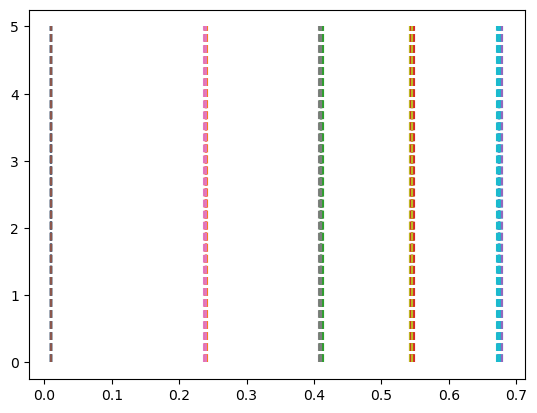

In [22]:
if blind:
    blinding = r.uniform(0,0.01, size=5)
else:
    blinding = np.zeros(5)

timepoints = np.zeros((datnum[dataset],5))
for i in range(datnum[dataset]):
    passnum = 0
    for j in range(len(data[i][1])-1):
        if (data[i][1][j]<4.5)*(data[i][1][j+1]>4.5):
            timepoints[i,passnum]+=data[0][0][j] + blinding[passnum]
            plt.plot([timepoints[i,passnum],timepoints[i,passnum]], [0,5], '--')
            passnum+=1

chi2 = 131.71438310058343, ndof = 2, p = 2.5037162960906684e-29
130.8923772503793 57.83631264556006 -0.6554610758531849


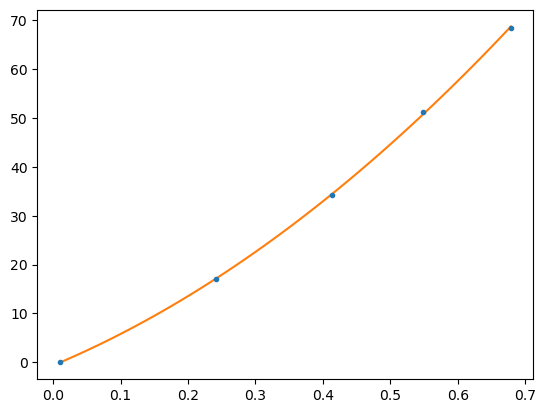

In [23]:
# fit of a single experiment
# Something bad happended to the chi2
# review gate_err, mihgt wanna consider moving away from own estimate of errors

plt.errorbar(timepoints[1], gate_pos, yerr=gate_err, fmt='.')
def fit_func(t, a, v0, s0):
    return 1/2 * a * t**2 + v0 * t + s0

def fit(fit, x, y, sy):
    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(fit, x, y, sy)
    minuit_chi2 = Minuit(chi2fit, a=1, v0=0.5, s0=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    return minuit_chi2

fit_result = fit(fit_func, timepoints[1], gate_pos, gate_err)
ndof = len(timepoints[1]) - 3
prob = stats.chi2.sf(fit_result.fval, ndof)

print(f"chi2 = {fit_result.fval}, ndof = {ndof}, p = {prob}")
x = np.linspace(timepoints[1][0], timepoints[1][-1], 100)
plt.plot(x, fit_func(x, *fit_result.values))
print(*fit_result.values)


In [24]:
from errorPropIncline import *

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>